In [9]:
#!kaggle competitions download -c tweet-sentiment-extraction

100%|██████████████████████████████████████| 1.39M/1.39M [00:01<00:00, 1.20MB/s]
100%|██████████████████████████████████████| 1.39M/1.39M [00:01<00:00, 1.20MB/s]


In [1]:
import pandas as pd
import numpy as np
import os

import emoji

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *


In [2]:
train = pd.read_csv("/Users/reejungkim/Documents/Git/Sentimental analysis/tweet-sentiment-extraction/train.csv")
test = pd.read_csv("/Users/reejungkim/Documents/Git/Sentimental analysis/tweet-sentiment-extraction/test.csv")

In [3]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [4]:
test.head()

textID                                               text sentiment
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative
3  01082688c6                                        happy bday!  positive
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive

# Data exploration

## checking for null values

In [5]:
train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [6]:
train.loc[pd.isnull(train.text)]

textID text selected_text sentiment
314  fdb77c3752  NaN           NaN   neutral

## drop null

In [7]:
train.dropna(inplace=True)

## count of unique values

In [8]:
train.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [9]:
train.shape, test.shape

((27480, 4), (3534, 3))

In [10]:
train.pivot_table(index='sentiment', values='textID', 
                  aggfunc='count', margins=True)


textID
sentiment        
negative     7781
neutral     11117
positive     8582
All         27480

In [11]:
train.pivot_table(index='sentiment', values='textID', 
                 aggfunc = lambda x: x.count()/train['sentiment'].count())


textID
sentiment          
negative   0.283151
neutral    0.404549
positive   0.312300

# Feature engineering

## URL 

In [12]:
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    if text!=[]:
        return "".join(text)
    return None

In [13]:
train['url']=train['text'].apply(lambda x:find_url(x))

In [14]:
train.loc[pd.notnull(train.url)]

textID                                               text  \
5      28b57f3990  http://www.dothebouncy.com/smf - some shameles...   
17     919fa93391  i`ve been sick for the past few days  and thus...   
35     4f5267ad70  Thats it, its the end. Tears for Fears vs Eric...   
50     a3ae670885   Then you should check out http://twittersucks...   
57     6086b1f016      will be back later.  http://plurk.com/p/rp3k7   
...           ...                                                ...   
27374  b49385ebb7   says Finally, Im home.  http://plurk.com/p/rr121   
27384  f94af8cb85  This is a much better tool than some I have co...   
27386  e149ebd3a1  #vwll2009 Would one of the VWLLers want to add...   
27463  a38bf809b0   LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MIS...   
27472  8f5adc47ec  http://twitpic.com/663vr - Wanted to visit the...   

                                           selected_text sentiment  \
5      http://www.dothebouncy.com/smf - some shameles...   neutral   
17                                                  sick  negative   
35                Thats it, its the end. Tears for Fears   neutral   
50     Then you should check out http://twittersucks....   neutral   
57                                   will be back later.   neutral   
...                                                  ...       ...   
27374                             says Finally, Im home.   neutral   
27384                         This is a much better tool  positive   
27386                                       ch appreciat  positive   
27463                                               MISS  negative   
27472                                      were too late  negative   

                                  url  
5      http://www.dothebouncy.com/smf  
17          http://tinyurl.com/mnf4kw  
35               http://bit.ly/2Hpbg4  
50            http://twittersucks.com  
57           http://plurk.com/p/rp3k7  
...                               ...  
27374        http://plurk.com/p/rr121  
27384        http://www.tweepular.com  
27386             http://bit.ly/BF5sh  
27463             http://bit.ly/r6RfC  
27472        http://twitpic.com/663vr  

[1221 rows x 5 columns]

## Emoticons

In [15]:
ex = "😍 lol 😆 😂 "
emoji.demojize(ex)

':smiling_face_with_heart-eyes: lol :grinning_squinting_face: :face_with_tears_of_joy: '

In [16]:
re.findall(':(.*?):', emoji.demojize(ex) )  #<-mac
#re.findall( r'\:(.*?)\:', emoji.demojize(ex) )  <- window

['smiling_face_with_heart-eyes',
 'grinning_squinting_face',
 'face_with_tears_of_joy']

In [17]:
emoji.UNICODE_EMOJI

{'🥇': ':1st_place_medal:',
 '🥈': ':2nd_place_medal:',
 '🥉': ':3rd_place_medal:',
 '🆎': ':AB_button_(blood_type):',
 '🏧': ':ATM_sign:',
 '🅰': ':A_button_(blood_type):',
 '🇦🇫': ':Afghanistan:',
 '🇦🇱': ':Albania:',
 '🇩🇿': ':Algeria:',
 '🇦🇸': ':American_Samoa:',
 '🇦🇩': ':Andorra:',
 '🇦🇴': ':Angola:',
 '🇦🇮': ':Anguilla:',
 '🇦🇶': ':Antarctica:',
 '🇦🇬': ':Antigua_&_Barbuda:',
 '♒': ':Aquarius:',
 '🇦🇷': ':Argentina:',
 '♈': ':Aries:',
 '🇦🇲': ':Armenia:',
 '🇦🇼': ':Aruba:',
 '🇦🇨': ':Ascension_Island:',
 '🇦🇺': ':Australia:',
 '🇦🇹': ':Austria:',
 '🇦🇿': ':Azerbaijan:',
 '🔙': ':BACK_arrow:',
 '🅱': ':B_button_(blood_type):',
 '🇧🇸': ':Bahamas:',
 '🇧🇭': ':Bahrain:',
 '🇧🇩': ':Bangladesh:',
 '🇧🇧': ':Barbados:',
 '🇧🇾': ':Belarus:',
 '🇧🇪': ':Belgium:',
 '🇧🇿': ':Belize:',
 '🇧🇯': ':Benin:',
 '🇧🇲': ':Bermuda:',
 '🇧🇹': ':Bhutan:',
 '🇧🇴': ':Bolivia:',
 '🇧🇦': ':Bosnia_&_Herzegovina:',
 '🇧🇼': ':Botswana:',
 '🇧🇻': ':Bouvet_Island:',
 '🇧🇷': ':Brazil:',
 '🇮🇴': ':British_Indian_Ocean_Territory:',
 '🇻🇬': ':British_Vir

In [18]:
def extract_emojis(string):
    emoticon = "".join(c for c in string if c in emoji.UNICODE_EMOJI)
    if emoticon!="":
        return emoticon
    return None

In [19]:
extract_emojis( "😊😳😏😁")

'😊😳😏😁'

In [20]:
extract_emojis('text without emojis')

In [21]:
train['emoji']=train['text'].apply(lambda x: extract_emojis(x))

In [22]:
train.loc[pd.notnull(train.emoji)]

Empty DataFrame
Columns: [textID, text, selected_text, sentiment, url, emoji]
Index: []

In [23]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment   url emoji  
0  I`d have responded, if I were going   neutral  None  None  
1                             Sooo SAD  negative  None  None  
2                          bullying me  negative  None  None  
3                       leave me alone  negative  None  None  
4                        Sons of ****,  negative  None  None

## Text preparation

### stopwords: words which does not add much meaning to a sentence

In [24]:
#nltk.download('stopwords') <- if error raises on nltk stopwords

stops = set(stopwords.words('english'))
stops

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

### stem extraction - Lemmatizing words

In [118]:
words =['fly', 'flies', 'flew', 'flown']

In [116]:
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

#types of stemmers
stemmerS = SnowballStemmer('english')  
stemmerP = PorterStemmer()
stemmerL = LancasterStemmer()

In [119]:
OutputSnowball=[stemmerS.stem(word) for word in words]
OutputPorter=[stemmerP.stem(word) for word in words]
OutputLancaster=[stemmerL.stem(word) for word in words]

print("using Snowball stemmer: ", OutputSnowball)
print("using Porter stemmer: ", OutputPorter)
print("using Lancaster stemmer: ", OutputLancaster)

using Snowball stemmer:  ['fli', 'fli', 'flew', 'flown']
using Porter stemmer:  ['fli', 'fli', 'flew', 'flown']
using Lancaster stemmer:  ['fly', 'fli', 'flew', 'flown']


In [120]:
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()
#nltk.download('wordnet')

In [122]:
Output=[lm.lemmatize(word, pos="v") for word in words]
print("using Lemmatizer: " , Output)

using Lemmatizer:  ['fly', 'fly', 'fly', 'fly']


# Tokenizer

In [137]:
def language_preprocessor(string):
    text =  re.sub('[^a-zA-Z]', ' ', string) #replace non-english with blank
    text = text.lower().split() #decapitalize texts
    text = [word for word in text if not word in stops] #remove stopword
    text = [lm.lemmatize(word) for word in text]  #lemmatization of texts
    return text #' '.join(text)
    

In [138]:
def language_preprocessor_append(string):
    text =  re.sub('[^a-zA-Z]', ' ', string) #replace non-english with blank
    text = text.lower().split() #decapitalize texts
    text = [word for word in text if not word in stops] #remove stopword
    text = [lm.lemmatize(word) for word in text]
    return ' '.join(text)

In [139]:
train['text processed'] = train['text'].apply(lambda x: language_preprocessor(x)) 
train['text processed append'] = train['text'].apply(lambda x: language_preprocessor_append(x)) 


In [140]:
train.head(3)

textID                                            text  \
0  cb774db0d1             I`d have responded, if I were going   
1  549e992a42   Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                       my boss is bullying me...   

                         selected_text sentiment   url emoji  \
0  I`d have responded, if I were going   neutral  None  None   
1                             Sooo SAD  negative  None  None   
2                          bullying me  negative  None  None   

                  text processed    text processed append  
0             [responded, going]          responded going  
1  [sooo, sad, miss, san, diego]  sooo sad miss san diego  
2                [bos, bullying]             bos bullying

# Commonly used words for each sentiment type

In [141]:
positive = train[train.sentiment=='positive']
negative = train[train.sentiment=='negative']
neutral = train[train.sentiment=='neutral']

In [142]:
from collections import Counter

def common_words(df, col, n):
    counts = Counter([item for sublist in df[col] for item in sublist])
    common_words = pd.DataFrame(counts.most_common(n))
    common_words.columns =['Word','count']
    return common_words
    

## positive

In [143]:
common_words_positive  = common_words(positive, 'text processed', 10)
common_words_positive

Word  count
0     day   1375
1    good   1068
2    love    950
3   happy    858
4  mother    677
5  thanks    570
6   great    483
7       u    447
8    like    434
9    hope    417

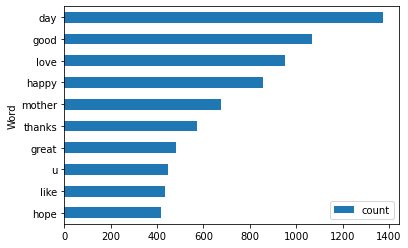

In [144]:
common_words_positive.set_index('Word').sort_values(
    by='count', ascending=True).plot(kind='barh')

In [145]:
import plotly.express as px

px.treemap(common_words_positive, 
           path=['Word'], values='count',
           title='Most commonly used Positive Words',
          width=400, height=400)

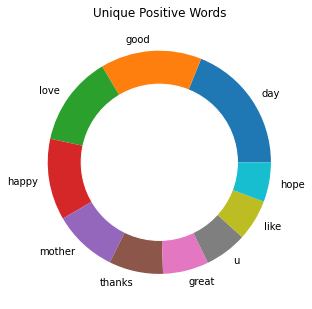

In [146]:
import matplotlib.pyplot as plt
#from palettable.colorbrewer.qualitative import Pastel1_7

plt.figure(figsize=(5,7))
my_circle=plt.Circle((0,0), 0.7, color='white')


plt.pie(common_words_positive['count'], 
        labels=common_words_positive.Word) #,colors=Pastel1_7.hex_colors)

p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Unique Positive Words')
plt.show()

### visualization with word cloud

In [147]:
common_words_positive  = common_words(positive, 'text processed', 100)

In [148]:
common_words_positive.set_index("Word")['count']

Word
day       1375
good      1068
love       950
happy      858
mother     677
          ... 
sleep      104
x          103
bit        103
people     103
gonna      102
Name: count, Length: 100, dtype: int64

In [149]:
words = common_words_positive.set_index("Word")['count'].to_dict()
words

{'day': 1375,
 'good': 1068,
 'love': 950,
 'happy': 858,
 'mother': 677,
 'thanks': 570,
 'great': 483,
 'u': 447,
 'like': 434,
 'hope': 417,
 'http': 414,
 'get': 392,
 'today': 360,
 'lol': 359,
 'fun': 352,
 'time': 349,
 'night': 347,
 'nice': 339,
 'one': 324,
 'go': 317,
 'really': 309,
 'got': 307,
 'morning': 298,
 'com': 294,
 'going': 286,
 'wish': 285,
 'awesome': 279,
 'mom': 279,
 'see': 276,
 'new': 275,
 'work': 273,
 'know': 262,
 'well': 260,
 'haha': 257,
 'back': 254,
 'much': 254,
 'thank': 249,
 'better': 221,
 'best': 221,
 'oh': 210,
 'would': 205,
 'home': 202,
 'im': 200,
 'think': 200,
 'make': 198,
 'look': 185,
 'twitter': 178,
 'cool': 176,
 'want': 176,
 'amazing': 174,
 'tonight': 171,
 'friend': 168,
 'tomorrow': 168,
 'last': 167,
 'weekend': 166,
 'still': 157,
 'though': 154,
 'week': 153,
 'thing': 153,
 'could': 150,
 'everyone': 146,
 'wait': 142,
 'say': 142,
 'come': 142,
 'guy': 141,
 'yay': 140,
 'need': 138,
 'right': 138,
 'twitpic': 134,
 

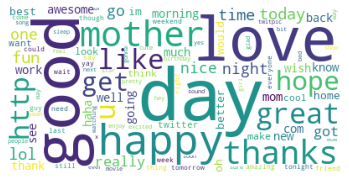

In [150]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', width=400, height=200)
wordcloud = wc.generate_from_frequencies(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## negative

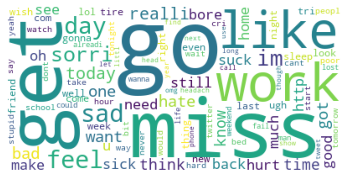

In [40]:
common_words_negative  = common_words(negative, 'text processed', 100)
words_negative = common_words_negative.set_index("Word")['count'].to_dict()

wordcloud = wc.generate_from_frequencies(words_negative)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

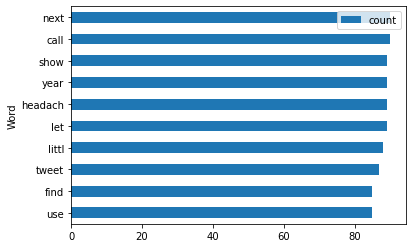

In [41]:
common_words_negative.set_index('Word').sort_values(
    by='count', ascending=True).head(10).plot(kind='barh')

# Vectorizing text.

In [355]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   textID          27480 non-null  object
 1   text            27480 non-null  object
 2   selected_text   27480 non-null  object
 3   sentiment       27480 non-null  object
 4   url             1221 non-null   object
 5   emoji           0 non-null      object
 6   text processed  27480 non-null  object
dtypes: object(7)
memory usage: 2.9+ MB


In [42]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment   url emoji  \
0  I`d have responded, if I were going   neutral  None  None   
1                             Sooo SAD  negative  None  None   
2                          bullying me  negative  None  None   
3                       leave me alone  negative  None  None   
4                        Sons of ****,  negative  None  None   

                        text processed          text processed append  
0                        [respond, go]                     respond go  
1        [sooo, sad, miss, san, diego]        sooo sad miss san diego  
2                        [boss, bulli]                     boss bulli  
3              [interview, leav, alon]            interview leav alon  
4  [son, put, releas, alreadi, bought]  son put releas alreadi bought

In [225]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer() #oov_token="<OOV>") #num_words=1000)
tokenizer.fit_on_texts(train['text processed'])

In [226]:
print(tokenizer.word_index)

{'day': 1, 'good': 2, 'get': 3, 'like': 4, 'go': 5, 'http': 6, 'u': 7, 'love': 8, 'work': 9, 'today': 10, 'going': 11, 'time': 12, 'got': 13, 'one': 14, 'lol': 15, 'happy': 16, 'know': 17, 'back': 18, 'really': 19, 'com': 20, 'im': 21, 'want': 22, 'see': 23, 'night': 24, 'mother': 25, 'think': 26, 'new': 27, 'home': 28, 'well': 29, 'still': 30, 'oh': 31, 'thanks': 32, 'much': 33, 'need': 34, 'miss': 35, 'hope': 36, 'great': 37, 'make': 38, 'feel': 39, 'last': 40, 'morning': 41, 'haha': 42, 'wish': 43, 'week': 44, 'twitter': 45, 'fun': 46, 'tomorrow': 47, 'would': 48, 'thing': 49, 'sorry': 50, 'tonight': 51, 'sad': 52, 'bad': 53, 'come': 54, 'look': 55, 'right': 56, 'friend': 57, 'yeah': 58, 'gonna': 59, 'say': 60, 'nice': 61, 'though': 62, 'mom': 63, 'way': 64, 'sleep': 65, 'better': 66, 'weekend': 67, 'could': 68, 'bit': 69, 'getting': 70, 'bed': 71, 'people': 72, 'hour': 73, 'hate': 74, 'next': 75, 'twitpic': 76, 'school': 77, 'guy': 78, 'show': 79, 'dont': 80, 'watching': 81, 'wait'

In [227]:
test_data = train['text processed']
test_data

0                                       [responded, going]
1                            [sooo, sad, miss, san, diego]
2                                          [bos, bullying]
3                                [interview, leave, alone]
4                     [son, put, release, already, bought]
                               ...                        
27476    [wish, could, come, see, u, denver, husband, l...
27477    [wondered, rake, client, made, clear, net, for...
27478    [yay, good, enjoy, break, probably, need, hect...
27479                                              [worth]
27480              [flirting, going, atg, smile, yay, hug]
Name: text processed, Length: 27480, dtype: object

In [228]:
x_train = tokenizer.texts_to_sequences(test_data.values)
#x_train = np.asarray(x_train)
x_train

[[9249, 11],
 [306, 52, 35, 1298, 2076],
 [1193, 9250],
 [909, 248, 382],
 [617, 220, 1194, 123, 463],
 [6, 283, 9251, 20, 9252, 9253, 4991, 85, 3580, 1820, 1157],
 [3581, 175, 46, 562, 6382],
 [464, 465],
 [],
 [1950, 154, 7, 2230, 3160, 414, 1109],
 [33, 8, 2845, 3161, 544, 6383, 98, 97, 59, 3, 494, 210],
 [19, 19, 4, 128, 8, 545, 935, 2077],
 [9254, 421, 9255, 760, 4992],
 [22, 5, 218, 51, 216, 860],
 [466, 466, 4136, 9256],
 [1242, 31, 2595],
 [94, 134, 2846, 4993, 1439, 467],
 [115, 536, 1, 3162, 221, 55, 6384, 297, 1369, 48, 55, 6, 201, 20, 9257, 9258],
 [18, 28, 59, 35, 288, 14],
 [984],
 [31, 9259, 50, 36, 132, 93],
 [278,
  1729,
  370,
  19,
  546,
  27,
  390,
  9260,
  1440,
  9261,
  1110,
  160,
  82,
  3163,
  1440],
 [537, 125, 226, 6385, 190, 10],
 [211, 6386, 373, 129, 359, 495, 220, 238, 2231, 9262],
 [23, 1074, 156, 508, 9263, 130, 9264, 391, 1075, 509, 9265, 124, 1158],
 [285, 9266, 829, 528, 46, 21, 1569],
 [50],
 [64, 4994, 360, 1111, 882],
 [2596, 340, 6387, 926

In [229]:
max_len = max(len(item) for item in x_train)
print(max_len)

25


In [230]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=5, padding='post', truncating='post')
x_train

array([[ 9249,    11,     0,     0,     0],
       [  306,    52,    35,  1298,  2076],
       [ 1193,  9250,     0,     0,     0],
       ...,
       [  143,     2,   244,   352,   281],
       [  569,     0,     0,     0,     0],
       [ 5699,    11, 22559,   562,   143]], dtype=int32)

from tensorflow.keras.utils import to_categorical
x_train = to_categorical(x_train)
x_train

In [231]:
from keras.layers import Embedding
from keras.models import Sequential
model.add(Embedding(vocabulary, input_length))

In [232]:
y_train = train.sentiment.replace({"neutral":0, 'positive': 1, 'negative':-1})
y_train = y_train.values


In [233]:
x_train.shape, y_train.shape

((27480, 5), (27480,))

In [248]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(5, activation="relu", kernel_initializer="uniform", input_shape=(5,) ))
#model.add(Dense(5, input_dim=5, activation="relu", kernel_initializer="uniform"))
model.add(Dense(1, activation='sigmoid'))

In [249]:

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [250]:
model.fit(x_train, y_train, epochs=10, batch_size=300, verbose=0)

In [251]:
results = model.evaluate(x_train, y_train)
results

27480/27480 [==============================] - 1s 20us/step


[-3.8775282947257095, 0.4012008607387543]